In [1]:
from pathlib import Path
from typing import Optional, List
import os
import json

from einops import rearrange
from timm import create_model
from torch.utils.data import DataLoader, Dataset
import lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2.functional as TF
import torchvision.transforms.v2 as transforms
import tifffile
import timm
import yaml


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils

In [5]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')

In [6]:
# case = 'HT206B1'
# train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s6_HT206B1-U10_multiplex.ome.tiff'
# train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s7_HT206B1-U12_he.tif'
# val_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s11_HT206B1-U18_multiplex.ome.tiff'
# val_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s12_HT206B1-U20_he.tif'

# exclusion_geojson = None

# target_channels = [
#     'Pan-Cytokeratin',
#     'SMA (D)',
#     'CD31',
#     'CD68',
#     'HLA-DR',
#     'CD8'
# ]

# he_dtype = 'he'

In [7]:
# case = 'HT704B1'
# train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s1_HT704B1-U11_multiplex.ome.tiff'
# train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif'
# val_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s40_HT704B1-U91_multiplex.ome.tiff'
# val_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s41_HT704B1-U93_he.tif'

# exclusion_geojson = '/data/estorrs/sandbox/ht704B1_s1_exclusion_regions.geojson'

# target_channels = [
#     'Pan-Cytokeratin',
#     'Keratin 5',
#     'CD31',
#     'CD68',
#     'HLA-DR',
#     'CD3e'
# ]

# he_dtype = 'he'

In [19]:
case = 'HT704B1'
target_channels = [
    'Pan-Cytokeratin',
    'Keratin 5',
    'CD31',
    'CD68',
    'HLA-DR',
    'CD3e'
]

exclusion_geojson = None
train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s24_HT704B1-U53_multiplex.ome.tiff'
train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U51_visiumhd_he.ome.tiff'
he_dtype = 'vishd'


val_multiplex_fp = train_multiplex_fp
val_he_fp = train_he_fp

In [20]:
# case = 'HT397B1'
# train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex.ome.tiff'
# train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he.tif'
# val_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s11_HT397B1-U31_multiplex.ome.tiff'
# val_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s10_HT397B1-U28_batch2_he.tif'

# exclusion_geojson = None

# target_channels = [
#     'Pan-Cytokeratin',
#     'Keratin 14',
#     'CD31',
#     'CD45 (D)',
#     'HLA-DR',
#     'CD8'
# ]

# he_dtype = 'batch2_he'

In [21]:
# case = 'HT891Z1'
# train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/s18_HT891Z1-U46_multiplex.ome.tiff'
# train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/s19_HT891Z1-U47_he.tif'
# val_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/s29_HT891Z1-U79_multiplex.ome.tiff'
# val_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/s28_HT891Z1-U70_he.tif'

# exclusion_geojson = None

# target_channels = [
#     'Pan-Cytokeratin',
#     'E-Cadherin',
#     'CK5',
#     'CD45(D)',
#     'HLA-DR',
#     'CD31',
#     'CD68',
#     'SMA (D)'
# ]

# he_dtype = 'he'

In [22]:
# case = 'HT891Z1'

# target_channels = [
#     'Pan-Cytokeratin',
#     'E-Cadherin',
#     'CK5',
#     'CD45(D)',
#     'HLA-DR',
#     'CD31',
#     'CD68',
#     'SMA (D)'
# ]

# exclusion_geojson = None
# train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/s11_HT891Z1-U32_multiplex.ome.tiff'
# train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/HT891Z1-U33_visiumhd_he.ome.tiff'
# he_dtype = 'vishd'


# val_multiplex_fp = train_multiplex_fp
# val_he_fp = train_he_fp

In [23]:
# case = 'HT913Z1'
# train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s1_HT913Z1-U2_multiplex.ome.tiff'
# train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s2_HT913Z1-U3_he.tif'
# val_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s55_HT913Z1-U91_multiplex.ome.tiff'
# val_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registered/s56_HT913Z1-U92_he.tif'

# exclusion_geojson = None

# target_channels = [
#     'Pan-Cytokeratin',
#     'E-Cadherin',
#     'CK5',
#     'CD45(D)',
#     'HLA-DR',
#     'CD31',
#     'CD68',
#     'SMA (D)'
# ]

# he_dtype = 'he'

In [24]:
multiplex.get_ome_tiff_channels(train_multiplex_fp)

['DAPI',
 'Granzyme B',
 'Keratin 5',
 'PLAT/tPA (D)',
 'CTLA4 (D)',
 'CD31',
 'CD4 (D)',
 'SLC39A6 (D)',
 'TCF-1',
 'BCA1',
 'CD68',
 'CD39',
 'FOXP3',
 'CD163',
 'PD-1',
 'MLPH',
 'CD8',
 'HER2 (D)',
 'GLUT1 (D)',
 'ckit-(D)',
 'Pan-Cytokeratin',
 'HIF1a',
 'Podoplanin (D)',
 'CD20',
 'HLA-DR',
 'CK14 (D)',
 'TFF1 (D)',
 'MGP (D)',
 'Ki67',
 'Vimentin',
 'CD3e',
 'E-cadherin',
 'SMA (D)',
 'cd11b',
 'PR (D)',
 'CD45 (D)',
 'GATA3',
 'COX6C (D)']

In [25]:
def geojson_to_mask(fp, size):
    d = json.load(open(fp))
    regions = [np.asarray(f['geometry']['coordinates'][0])
           for f in d['features'] if f['geometry']['type'] == 'Polygon']
    mask = np.zeros(size, dtype=bool)
    for region in regions:
        mask = mask | skimage.draw.polygon2mask(train_multiplex.shape[1:], region[:, [1, 0]])
    return mask
    

In [26]:
def to_he(x, norm=None):
    if x.shape[0] == 3:
        x = rearrange(x, 'c h w -> h w c')
    
    if norm is not None:
        x *= rearrange(np.asarray(norm.std), 'n -> 1 1 n')
        x += rearrange(np.asarray(norm.mean), 'n -> 1 1 n')
    
    if not isinstance(x, np.ndarray):
        x = x.numpy()

    return x.astype(np.uint8)

In [27]:
metadata = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'HT704B1-U1'},
  {'data': [{'dtype': 'vishd',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U2_visiumhd.h5ad'}],
   'position': 5,
   'sid': 'HT704B1-U2'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s1_HT704B1-U11_multiplex.ome.tiff'}],
   'position': 50,
   'sid': 'HT704B1-U11'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif'}],
   'position': 55,
   'sid': 'HT704B1-U12'},
  {'data': [{'dtype': 'cosmx',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/H

In [28]:
scales = [1, 2, 4, 8]

In [29]:
d = multiplex.extract_ome_tiff(train_multiplex_fp, channels=target_channels)
train_multiplex = np.stack([d[k] for k in target_channels])
d = multiplex.extract_ome_tiff(val_multiplex_fp, channels=target_channels)
val_multiplex = np.stack([d[k] for k in target_channels])

train_he = tifffile.imread(train_he_fp)
val_he = tifffile.imread(val_he_fp)

if train_he.shape[0] == 3:
    train_he = rearrange(train_he, 'c h w -> h w c')
if val_he.shape[0] == 3:
    val_he = rearrange(val_he, 'c h w -> h w c')

In [30]:
if exclusion_geojson is not None:
    exclusion_mask = geojson_to_mask(exclusion_geojson, train_multiplex.shape[1:])
    plt.imshow(exclusion_mask)
else:
    exclusion_mask = None

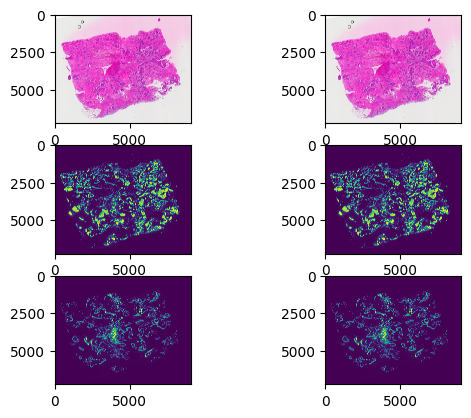

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=2)
ax[0, 0].imshow(train_he)
ax[0, 1].imshow(val_he)
ax[1, 0].imshow(train_multiplex[0])
ax[1, 1].imshow(val_multiplex[0])
ax[2, 0].imshow(train_multiplex[1])
ax[2, 1].imshow(val_multiplex[1])

In [32]:
train_he = rearrange(train_he, 'h w c -> c h w').astype(np.float32)
val_he = rearrange(val_he, 'h w c -> c h w').astype(np.float32)

train_multiplex = train_multiplex.astype(np.float32)
val_multiplex = val_multiplex.astype(np.float32)

In [33]:
means, stds = train_he.mean((-2, -1)), train_he.std((-2, -1))
norm = transforms.Normalize(means, stds)
means, stds

(array([229.3961 , 153.97795, 215.8374 ], dtype=float32),
 array([22.824644, 78.82187 , 20.344294], dtype=float32))

In [34]:
train_hes = [utils.rescale(train_he, scale=1 / scale, dim_order='c h w', target_dtype=np.float32)
             for scale in scales]
val_hes = [utils.rescale(val_he, scale=1 / scale, dim_order='c h w', target_dtype=np.float32)
           for scale in scales]

for x in train_hes:
    print(x.shape)

(3, 7250, 9060)
(3, 3625, 4530)
(3, 1812, 2265)
(3, 906, 1132)


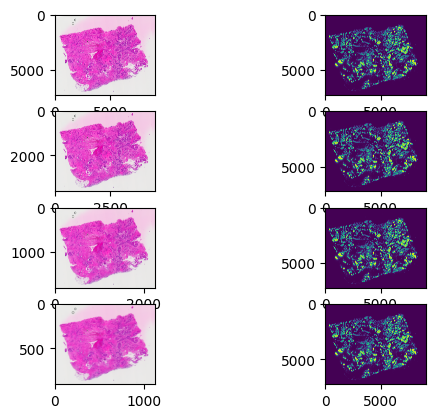

In [35]:
fig, axs = plt.subplots(nrows=len(scales), ncols=2)
for i, he in enumerate(train_hes):
    axs[i, 0].imshow(to_he(he))
    axs[i, 1].imshow(train_multiplex[0])

In [36]:
multiplex_maxs = train_multiplex.max((-2, -1))
multiplex_maxs

array([255., 255., 255., 255., 255., 255.], dtype=float32)

In [37]:
train_hes = [torch.tensor(x) for x in train_hes]
val_hes = [torch.tensor(x) for x in val_hes]

train_multiplex = torch.tensor(train_multiplex / rearrange(multiplex_maxs, 'n -> n 1 1'))
val_multiplex = torch.tensor(val_multiplex / rearrange(multiplex_maxs, 'n -> n 1 1'))

In [38]:
class TrainingTransform(object):
    def __init__(self, norm):
        self.norm = norm

    def __call__(self, he_tiles, y_tile):
        vflip = np.random.rand() > .5
        hflip = np.random.rand() > .5
        
        if hflip:
            he_tiles = [TF.hflip(tile) for tile in he_tiles]
            y_tile = TF.hflip(y_tile)
        
        if vflip:
            he_tiles = [TF.vflip(tile) for tile in he_tiles]
            y_tile = TF.vflip(y_tile)
            
        he_tiles = [self.norm(tile) for tile in he_tiles]

        return he_tiles, y_tile
    
class ValTransform(object):
    def __init__(self, norm):
        self.norm = norm

    def __call__(self, he_tiles, y_tile):
        he_tiles = [self.norm(tile) for tile in he_tiles]
        
        return he_tiles, y_tile
    
class InferenceTransform(object):
    def __init__(self, norm):
        self.norm = norm

    def __call__(self, he_tiles):
        he_tiles = [self.norm(tile) for tile in he_tiles]
        
        return he_tiles

In [39]:
class TrainingDataset(Dataset):
    def __init__(self, hes, y, scales, transform, size=256, n=None, exclusion_mask=None):
        assert hes[0].shape[1:] == y.shape[1:]
        assert len(scales) == len(hes)
        
        if exclusion_mask is not None:
            assert exclusion_mask.shape == y.shape[1:]
        
        self.n_zooms = len(hes)
        self.scales = scales
        
        self.hes = hes
        self.y = y
        
        self.h, self.w = hes[0].shape[1:]
        self.size = size
        self.hs = np.arange(self.h - size - 1)
        self.ws = np.arange(self.w - size - 1)
        
        if exclusion_mask is not None:
            hs, ws = [], []
            for h, w in zip(self.hs, self.ws):
                if not exclusion_mask[h, w]:
                    hs.append(h)
                    ws.append(w)
            self.hw, self.ws = hs, ws
        
        self.zoom_to_coords = []
        for i, scale in enumerate(self.scales):
            hs = [x + self.size // 2 for x in self.hs] # to center
            ws = [x + self.size // 2 for x in self.ws]
            
            hs = [x // scale for x in hs] # scale
            ws = [x // scale for x in ws]
            
            hs = [x - self.size // 2 for x in hs] # to top left corner
            ws = [x - self.size // 2 for x in ws]
            
            self.zoom_to_coords.append([hs, ws])

        self.transform = transform

        self.n = np.iinfo(np.int64).max if n is None else n

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        h_idx, w_idx = np.random.choice(np.arange(len(self.hs))), np.random.choice(np.arange(len(self.ws)))

        he_tiles = []
        y_tile = None
        h_coord, w_coord = None, None
        for i, ((hs, ws), scale, he) in enumerate(zip(self.zoom_to_coords, self.scales, self.hes)):
            h, w = hs[h_idx], ws[w_idx]
            left, top, right, bottom = 0, 0, 0, 0
            if h < 0:
                top = abs(h)
            if w < 0:
                left = abs(w)
            if h + self.size >= he.shape[-2]:
                bottom = h + self.size - he.shape[-2]
            if w + self.size >= he.shape[-1]:
                right = w + self.size - he.shape[-1]
            
            r, c = max(h, 0), max(w, 0)
            he_tiles.append(TF.pad(
                he[:, r:r + self.size - top, c:c + self.size - left],
                padding=(left, top, right, bottom), 
                padding_mode='reflect'
            ))
            
            if i == 0:
                y_tile = TF.pad(
                    self.y[:, r:r + self.size - top, c:c + self.size - left],
                    padding=(left, top, right, bottom), 
                    padding_mode='reflect'
                )
                h_coord, w_coord = r, c
                
        he_tiles, y_tile = self.transform(he_tiles, y_tile)   

        return {
            'h_coord': h_coord,
            'w_coord': w_coord,
            'he': he_tiles,
            'y': y_tile,
        }
    
class InferenceDataset(Dataset):
    def __init__(self, hes, scales, transform, size=256, stride=None):
        assert len(scales) == len(hes)
        
        self.stride = stride
        if stride is None:
            self.stride = size
        
        self.n_zooms = len(hes)
        self.scales = scales
        
        self.hes = hes
        
        self.h, self.w = hes[0].shape[1:]
        self.size = size
        self.hs = []
        self.ws = []
        for h in np.arange(0, self.h - size - 1, stride):
            for w in np.arange(0, self.w - size - 1, stride):
                self.hs.append(h)
                self.ws.append(w)
        
        self.zoom_to_coords = []
        for i, scale in enumerate(self.scales):
            hs = [x + self.size // 2 for x in self.hs] # to center
            ws = [x + self.size // 2 for x in self.ws]
            
            hs = [x // scale for x in hs] # scale
            ws = [x // scale for x in ws]
            
            hs = [x - self.size // 2 for x in hs] # to top left corner
            ws = [x - self.size // 2 for x in ws]
            
            self.zoom_to_coords.append([hs, ws])

        self.transform = transform

        self.n = len(self.hs)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        he_tiles = []
        h_coord, w_coord = None, None
        for i, ((hs, ws), scale, he) in enumerate(zip(self.zoom_to_coords, self.scales, self.hes)):
            h, w = hs[idx], ws[idx]
            left, top, right, bottom = 0, 0, 0, 0
            if h < 0:
                top = abs(h)
            if w < 0:
                left = abs(w)
            if h + self.size >= he.shape[-2]:
                bottom = h + self.size - he.shape[-2]
            if w + self.size >= he.shape[-1]:
                right = w + self.size - he.shape[-1]
            
            r, c = max(h, 0), max(w, 0)
            he_tiles.append(TF.pad(
                he[:, r:r + self.size - top, c:c + self.size - left],
                padding=(left, top, right, bottom), 
                padding_mode='reflect'
            ))
            
            if i == 0:
                h_coord, w_coord = r, c

        he_tiles = self.transform(he_tiles)   

        return {
            'h_coord': h_coord,
            'w_coord': w_coord,
            'he': he_tiles,
        }
    
    

In [40]:
size = 256
batch_size = 64

In [41]:
train_transform = TrainingTransform(norm)
train_ds = TrainingDataset(
    train_hes, train_multiplex, scales, train_transform,
    size=size, n=batch_size * 100, exclusion_mask=exclusion_mask)

val_transform = ValTransform(norm)
val_ds = TrainingDataset(val_hes, val_multiplex, scales, val_transform, size=size, n=batch_size * 10)

In [42]:
"""
https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31

A simple U-Net w/ timm backbone encoder
Based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
Hacked together by Ross Wightman
"""

from typing import Optional, List
import torch.nn as nn
from timm import create_model


class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet50',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=True, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [43]:
class Model(nn.Module):
    def __init__(
            self,
            size=256,
            n_zooms=3,
            backbone='resnet18',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=3,
            out_chans=1,
            center=False,
            norm_layer=nn.BatchNorm2d,
        ):
        super().__init__()
        
        self.size = size
        self.n_zooms = n_zooms
        
        self.unets = torch.nn.ModuleList([Unet(
            backbone=backbone,
            backbone_kwargs=backbone_kwargs,
            backbone_indices=backbone_indices,
            decoder_use_batchnorm=decoder_use_batchnorm,
            decoder_channels=decoder_channels,
            in_chans=in_chans,
            num_classes=out_chans,
            center=center,
            norm_layer=norm_layer,
        ) for n in range(n_zooms)])
        
        self.head = nn.Sequential(
            nn.Conv2d(n_zooms * out_chans, out_chans, 1),
            nn.ReLU(),
            nn.Conv2d(out_chans, out_chans, 1),
            nn.ReLU(),
            nn.Conv2d(out_chans, out_chans, 1),
            nn.ReLU(),
            nn.Conv2d(out_chans, out_chans, 1),
            nn.Sigmoid(),
        )
    
    def calculate_loss(self, x, y):
        return F.mse_loss(x, y)

    def forward(self, hes):
        activations = torch.concat([unet(x) for unet, x in zip(self.unets, hes)], dim=1)
        return self.head(activations)
    
    
class LitModel(pl.LightningModule):
    def __init__(
            self,
            size=256,
            scales=[1,2,4],
            backbone='resnet18',
            batch_size=64,
            lr=1e-4,
            total_steps=1,
            out_chans=1,
            ):
        super().__init__()
        self.size = size
        self.scales = scales
        self.batch_size = batch_size
        self.lr = lr

        self.model = Model(
            size=size,
            n_zooms=len(scales),
            backbone=backbone,
            out_chans=out_chans,
        )

        self.outputs = None

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        hes, y = batch['he'], batch['y']
        outs = self.forward(hes, y)
        self.log_dict(
            {f'train_{k}_step':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=False, prog_bar=True, batch_size=self.batch_size
        )
        self.log_dict(
            {f'train_{k}_epoch':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size
        )
        return outs

    def validation_step(self, batch, batch_idx):
        hes, y = batch['he'], batch['y']
        outs = self.forward(hes, y)
        self.log_dict(
            {f'val_{k}_step':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=False, prog_bar=True, batch_size=self.batch_size
        )
        self.log_dict(
            {f'val_{k}_epoch':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size
        )
        return outs
    
    def predict_step(self, batch):
        hes = batch['he']
        return self.model(hes)
    

    def forward(self, hes, y):
        preds = self.model(hes)
        return {
            'loss': self.model.calculate_loss(preds, y),
            'outputs': preds
        }


In [44]:
model = LitModel(
    size=size,
    scales=scales,
    backbone='resnet18',
    batch_size=batch_size, 
    out_chans=len(target_channels)
)

In [45]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=1)

In [46]:
run_dir = project_dir / case / 'multiplex_prediction'
log_dir = run_dir / f'logs_{he_dtype}'
output_dir = run_dir / f'predictions_{he_dtype}'
log_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

In [47]:
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=100,
    logger=pl.pytorch.loggers.TensorBoardLogger(save_dir=log_dir)
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(
    model,
    train_dl,
    val_dl
)

Missing logger folder: /data/estorrs/mushroom/data/projects/submission_v1/HT704B1/multiplex_prediction/logs_vishd/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 57.3 M | train
----------------------------------------
57.3 M    Trainable params
0         Non-trainable params
57.3 M    Total params
229.252   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [49]:
chkpt_path = run_dir / 'model.ckpt'

In [50]:
torch.save(model.state_dict(), chkpt_path)

In [51]:
# model = LitModel(
#     size=size,
#     scales=scales,
#     backbone='resnet18',
#     batch_size=batch_size,
#     out_chans=len(target_channels)
# )
# model.load_state_dict(torch.load(chkpt_path))

In [52]:
he_fps = [entry['data'][0]['filepath'] for entry in metadata['sections']
         if entry['data'][0]['dtype'] == he_dtype]
if he_dtype == 'vishd':
    he_fps = [fp.replace('.h5ad', '_he.ome.tiff') for fp in he_fps]

he_fps = [fp.replace('/diskmnt/Projects/Users', '/data') for fp in he_fps]
he_fps

['/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U2_visiumhd_he.ome.tiff',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U51_visiumhd_he.ome.tiff']

In [53]:
def tile_predictions(dl, outputs, size, stride=None):
    if stride is None:
        stride = size
    padding = stride // 2

    max_h, max_w = max(dl.dataset.hs) + size, max(dl.dataset.ws) + size
    tiled_pred = torch.zeros((len(target_channels), max_h, max_w), dtype=torch.float32)
    tiled_he = torch.zeros((3, max_h, max_w), dtype=torch.float32)
    
    min_val_r, max_val_r = min(dl.dataset.hs), max(dl.dataset.hs)
    min_val_c, max_val_c = min(dl.dataset.ws), max(dl.dataset.ws)

    for b, outs in zip(dl, outputs):
        for i, (r, c) in enumerate(zip(b['h_coord'], b['w_coord'])):
            r1, r2 = r + padding, r + size - padding
            c1, c2 = c + padding, c + size - padding
            
            local_r1, local_r2, local_c1, local_c2 = padding, size - padding, padding, size - padding
            if r == min_val_r:
                r1 -= padding
                local_r1 -= padding
            if r == max_val_r:
                r2 += padding
                local_r2 += padding
            if c == min_val_c:
                c1 -= padding
                local_c1 -= padding
            if c == max_val_c:
                c2 += padding
                local_c2 += padding

            tiled_pred[:, r1:r2, c1:c2] = outs[i][:, local_r1:local_r2, local_c1:local_c2]
            tiled_he[:, r1:r2, c1:c2] = b['he'][0][i][:, local_r1:local_r2, local_c1:local_c2]
    return tiled_pred, tiled_he

In [54]:
stride = size // 2
pred_transform = InferenceTransform(norm)
tiled_preds, tiled_hes = [], []
if he_dtype in ['he', 'batch2_he']:
    sids = [fp.split('/')[-1].replace(f'_{he_dtype}.tif', '') for fp in he_fps]
elif he_dtype == 'vishd':
    sids = [fp.split('/')[-1].replace(f'_visiumhd_he.ome.tiff', '') for fp in he_fps]
for sid, fp in zip(sids, he_fps):
    print(fp)
    x = tifffile.imread(fp)
    if x.shape[-1] == 3:
        x = rearrange(x, 'h w c -> c h w')
    xs = [utils.rescale(x, scale=1 / scale, dim_order='c h w', target_dtype=x.dtype)
                 for scale in scales]
    xs = [torch.tensor(x.astype(np.float32)) for x in xs]

    ds = InferenceDataset(xs, scales, pred_transform, size=size, stride=stride)
    dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=1)
    outputs = trainer.predict(model, dl)
    
    tiled_pred, tiled_he = tile_predictions(dl, outputs, size, stride=stride)
    x = tiled_pred.numpy() * rearrange(multiplex_maxs, 'n -> n 1 1')
    x = x.astype(np.uint8)
    
    fp = output_dir / f'{sid}.ome.tif'
    j
    multiplex.write_basic_ome_tiff(fp, x, target_channels, subresolutions=1) # subres of 1 bc pyramidal doesn't save on glacier for some reason
    
#     tiled_preds.append(tiled_pred)
#     tiled_hes.append(tiled_he)


/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U2_visiumhd_he.ome.tiff


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U51_visiumhd_he.ome.tiff


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [55]:
output_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/multiplex_prediction/predictions_vishd')

In [42]:
# for tiled_pred, tiled_he in zip(tiled_preds, tiled_hes):
#     fig, axs = plt.subplots(ncols=1 + len(target_channels))
#     axs[0].imshow(to_he(tiled_he, norm=norm))
#     for i in range(len(target_channels)):
#         axs[i + 1].imshow(tiled_pred[i])
    
#     for ax in axs:
#         ax.axis('off')
#     plt.show()

In [ ]:
# he_fps[18]

In [ ]:
# val_he_fp

In [ ]:
# r1, r2, c1, c2 = 1000, 3000, 500, 2500
# idx = 18

# def plot_tiles(idx, bbox):
#     r1, r2, c1, c2 = bbox
    
#     nrows = len(target_channels)
#     fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(10, 3 * nrows))
#     for i, c in enumerate(target_channels):
#         axs[i, 0].imshow(tiled_preds[idx][i, r1:r2, c1:c2])
#         axs[i, 1].imshow(val_multiplex[i, r1:r2, c1:c2])
#         axs[i, 2].imshow(to_he(tiled_hes[idx][:, r1:r2, c1:c2], norm=norm))

#         axs[i, 0].set_ylabel(c, rotation=90)

#     axs[0, 0].set_title('predicted')
#     axs[0, 1].set_title('true')
#     axs[0, 2].set_title('he')

#     for ax in axs.flatten():
#         ax.set_xticks([])
#         ax.set_yticks([])

# plot_tiles(idx, (r1, r2, c1, c2))

In [ ]:
# r1, r2, c1, c2 = 3000, 5000, 500, 2500

# plot_tiles(idx, (r1, r2, c1, c2))

In [ ]:
# sids = [fp.split('/')[-1].replace('_he.tif', '') for fp in he_fps]
# for sid, x in zip(sids, tiled_preds):
#     print(sid)
#     x = x.numpy()
#     x *= rearrange(multiplex_maxs, 'n -> n 1 1')
#     x = x.astype(np.uint8)
    
#     fp = output_dir / f'{sid}.ome.tif'
    
#     multiplex.write_basic_ome_tiff(fp, x, target_channels)
    
